<a href="https://colab.research.google.com/github/Fernando123Duran/Asistente_Composici-n_musical/blob/main/Notbooks/sprint_3/3_gptmin_compositor_musical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/Colab/proyecto_perfil/modelo/minGPT'

Mounted at /gdrive
/gdrive/My Drive/Colab/proyecto_perfil/modelo/minGPT


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 21.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=da39827665c4a3026b5b933b76d77e63fe24344bf7141182c57ab73b55a23a71
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [20]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///gdrive/MyDrive/Colab/proyecto_perfil/modelo/minGPT
  Preparing metadata (setup.py) ... done
  Running setup.py develop for minGPT


In [ ]:
# Ejecutar solo la primera vez cuando se prepara el entorno de trabajo
# !git clone https://github.com/karpathy/minGPT.git 

In [3]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 11.4 MB/s eta 0:00:00


In [4]:
import torch
import numpy as np
import json
import pytorch_lightning as pl  

In [5]:
from sklearn.model_selection import train_test_split
def cargarArchivosNPY(path):
    with open(path, 'rb') as f:
        datos = np.load(f,allow_pickle=True)
        datosCompletos=[]
        datos=datos.tolist()
        for da in datos:
          datosCompletos.append(np.array(datos[da]))
        print(len(datosCompletos))
        entre, valid= train_test_split(datosCompletos, shuffle=False,train_size=0.9)
        print(len(entre))
        print(len(valid))
    
def cargarVocabulario(pathVocabulario):
    with open(pathVocabulario, "r") as fp:
        mappings = json.load(fp)
    return mappings

In [ ]:
# cargarArchivosNPY("../../archivos_numpy/datasetCompleto.npy")


In [6]:
vocab=cargarVocabulario("../../vocabulario/vocabulario2022.json")
len(vocab)

146

In [7]:
vocabReves=cargarVocabulario("../../vocabulario/vocabulario_inverso_2022.json")
len(vocab)

146

In [ ]:
# datosCompletos=[]
# datos=datos.tolist()
# for da in datos:
#   datosCompletos.append(np.array(datos[da]))

# datosCompletos[0]

In [ ]:
# datos= datos.tolist()
# datos=np.array(datos)
# datos

In [ ]:
# datoPrueba= datos.tolist()
# datoPrueba=np.array(datoPrueba["0"])
# len(datoPrueba)

In [17]:

class Dataset(torch.utils.data.Dataset):

  def __init__(self, examples,sizeBlock):
    self.examples = examples
    self.sizeBlock = sizeBlock

  def __len__(self):
    return len(self.examples)
   
  def __getitem__(self, ix):
    dato=self.examples[ix]
    entrada=dato[:-1]
    salida = dato[1:]
    input = np.pad(entrada, (0,self.sizeBlock-len(entrada)), 'constant', constant_values=0)
    target = np.pad(salida, (0,self.sizeBlock-len(salida)), 'constant', constant_values=0)
    assert len(input) == self.sizeBlock
    assert len(target) == self.sizeBlock
    return torch.LongTensor(input), torch.LongTensor(target)

In [18]:
from sklearn.model_selection import train_test_split
class DataModuleLinghtning(pl.LightningDataModule):
  def __init__(self, pathDatos="../../archivos_numpy/dataAumentation.npy",batch_size=25):
    self.pathDatos=pathDatos
    self.batch_size=batch_size
    self.entre=None
    self.valid=None

  def setup(self,stage=None):
    with open(self.pathDatos, 'rb') as f:
      datos = np.load(f,allow_pickle=True)
    datosCompletos=[]
    datos=datos.tolist()
    for da in datos:
      datosCompletos.append(np.array(datos[da]))
    entrep, validp= train_test_split(datosCompletos, shuffle=True,train_size=0.9)
    self.entre=Dataset(examples=entrep,sizeBlock=768)
    self.valid=Dataset(examples=validp,sizeBlock=768)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.entre, batch_size=self.batch_size, shuffle=True, pin_memory=True)
  
  def valid_dataloader(self):
    return torch.utils.data.DataLoader(self.valid, batch_size=self.batch_size, shuffle=False, pin_memory=True)
    



In [19]:
dataSetEntre=DataModuleLinghtning()
dataSetEntre.setup()

In [ ]:
# x, y = next(iter(dataSetEntre.train_dataloader()))
# x.shape, y.shape

In [21]:
from mingpt.model import GPT
from mingpt.trainer import Trainer
class Module(pl.LightningModule):
	def __init__(self):
		super().__init__()
		model_config = GPT.get_default_config()
		model_config.model_type = 'gpt2'
		model_config.vocab_size =len(vocab) # openai's model vocabulary
		model_config.block_size = 768
		train_config = Trainer.get_default_config()
		train_config.learning_rate = 5e-4 # many possible options, see the file
		self.model = GPT(model_config)
		self.tconf = train_config

	def forward(self, x):
		# print(x)
		salidaMod=self.model(x)
		# print(salidaMod)
		return salidaMod[0]

	def training_step(self, batch, batch_idx):
		# print(batch)
		# print(*batch[0].size())
		y, loss = self.model(*batch)
		self.log("train/loss", loss)
		self.log('loss_train',loss,on_step=True, prog_bar=True, logger=True)
		return loss 

	def validation_step(self, batch, batch_idx):
		y, loss = self.model(*batch)
		# print(loss)
		self.log('val_loss', loss.item(),on_step=True, prog_bar=True, logger=True)

	def configure_optimizers(self):
		return self.model.configure_optimizers(self.tconf)

In [ ]:
# from mingpt.model import GPT
# model_config = GPT.get_default_config()
# model_config.model_type = 'gpt2'
# model_config.vocab_size =len(vocab) # openai's model vocabulary
# model_config.block_size = 768


# model = GPT(model_config)

# model

In [ ]:
# from mingpt.trainer import Trainer
# train_config = Trainer.get_default_config()
# train_config.learning_rate = 5e-4 # many possible options, see the file
# train_config.batch_size=2



In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
wandb_logger = WandbLogger(project="final2")
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
		every_n_epochs=50,
    monitor="val_loss",
    mode="min",
    dirpath="../guardarModelo/",
    filename="modelo-v1-{epoch:02d}-{val_loss:.2f}={loss_train:.2f}",
)
# early_stop_callbaack=EarlyStopping(
# 		monitor='val_loss',
# 		patience=3,
# 		verbose=True,
# 		mode='min',
# )

module=Module()
trainer = pl.Trainer(
	gpus=1,
	precision=16,
	max_epochs=1001,
	logger=wandb_logger,
	callbacks=[
		checkpoint_callback,
]
)

trainer.fit(module, dataSetEntre.train_dataloader(),dataSetEntre.valid_dataloader())
trainer.save_checkpoint("../../modelo/guardarModelo/Epoch1000.ckpt")

number of parameters: 85.76M


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 85.9 M
-------------------------------
85.9 M    Trainable params
0         N

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
entr=[51,31,47,113,8,120,6,116,6]
partEntrada=np.array(entr)
entr= torch.LongTensor(entr)
entr=entr.expand(1,-1)
entr.shape

torch.Size([1, 19])

In [ ]:
input_sample = torch.randint(0, 146, (1,768), dtype=torch.uint8)
input_sample.shape

torch.Size([1, 768])

In [22]:
module=Module()

number of parameters: 85.76M


In [23]:
model2 = module.load_from_checkpoint("../../modelo/guardarModelo/modelo-v1-epoch=149-val_loss=0.02=loss_train=0.02.ckpt")

number of parameters: 85.76M


In [ ]:
import pytorch_lightning

filepath = "../../modelo/guardarModelo/Epoch150.onnx"
input_sample =input_sample.to(torch.int64)
model2.to_onnx(filepath, 
               input_sample, 
               export_params=True,
               input_names = ['input'],  
                output_names = ['output'], 
                dynamic_axes={'input' : {0 : 'batch_size',1 : 'notas'},'output' : {0 : 'batch_size',1 : 'notas'}}
               )

/gdrive/MyDrive/Colab/proyecto_perfil/modelo/minGPT/mingpt/model.py:263: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
/gdrive/MyDrive/Colab/proyecto_perfil/modelo/minGPT/mingpt/model.py:62: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))


In [24]:

model2.model.eval()
new_words = 300
y = model2.model.generate(entr, new_words)

y 

tensor([[ 51,  31,  47, 113,   8, 120,   6, 116,   6, 113,   6, 111,   8,  26,
           6, 116,   6, 120,   6, 123,   8, 121,   6, 125,   6, 123,   8, 120,
           6, 118,   6, 116,   6, 118,   6, 116,   8,  26,   6, 116,   6, 116,
           6, 113,   6, 113,   6, 111,   6,  26,   6, 116,   6, 116,   6, 116,
           6, 113,   6, 111,   6, 109,   8,  26,   6, 108,   6, 108,   6, 111,
           6, 109,   6, 108,   6, 106,   6, 104,   6,  22,  27, 106,   9,  26,
           6,  30,  23,  27,  24, 106,   6, 106,   6, 106,   6, 106,   6,  28,
          25,   2,   2, 109,   6, 113,   6, 113,   6,  28,  25,   2,   2,   2,
           2, 109,   6, 113,   6, 113,   6,  28,  25,   2,   2,   2,   6, 118,
           6, 116,   6, 115,   6, 113,   6, 111,   9,  26,   6,  28,   2,   2,
           2, 118,   6, 118,   6, 118,   6, 116,   6, 115,   6, 116,   6, 118,
           8, 116,   6, 115,   6, 116,   6, 115,   6, 113,   6, 115,   6, 116,
           6, 113,   6, 111,   6, 113,   6,  22,  27

In [25]:
# partitura=[ 51,  31,  47, 113,   8, 120,   6, 116,   6, 113,   6, 111,   8,  26,
#            6, 116,   6, 120,   6, 123,   8, 121,   6, 125,   6, 123,   8, 120,
#            6, 118,   6, 116,   6, 118,   6, 116,   8,  26,   6, 116,   6, 116,
#            6, 113,   6, 113,   6, 111,   6,  26,   6, 116,   6, 116,   6, 116,
#            6, 113,   6, 111,   6, 109,   8,  26,   6, 108,   6, 108,   6, 111,
#            6, 109,   6, 108,   6, 106,   6, 104,   6,  22,  27, 106,   9,  26,
#            6,  30,  23,  27,  24, 106,   6, 106,   6, 106,   6, 106,   6,  28,
#           25,   2,   2, 109,   6, 113,   6, 113,   6,  28,  25,   2,   2,   2,
#            2, 109,   6, 113,   6, 113,   6,  28,  25,   2,   2,   2,   6, 118,
#            6, 116,   6, 115,   6, 113,   6, 111,   9,  26,   6,  28,   2,   2,
#            2, 118,   6, 118,   6, 118,   6, 116,   6, 115,   6, 116,   6, 118,
#            8, 116,   6, 115,   6, 116,   6, 115,   6, 113,   6, 115,   6, 116,
#            6, 113,   6, 111,   6, 113,   6,  22,  27, 111,   9,  26,   6,  30,
#           23,  27,  24, 111,   6, 113,   6, 113,   6, 113,   6, 109,   6,  28,
#           25,   2,   2,  28,  25,   2,   2,   2,   2,   2, 106,   6, 109,   6,
#          113,   6, 118,   6, 121,   6,  28,  25,   2,   2, 118,   6, 116,   6,
#          113,   6, 115,   6, 116,   8,  26,   8,  26,   8,  28,   2,   2,   2,
#          116,   6, 118,   6, 119,   6, 118,   6, 118,   6, 121,   6, 118,   6,
#          120,   6, 118,   6, 116,   6, 115,   6, 116,   6, 115,   6, 113,   6,
#          112,   6, 113,   6, 111,   6, 113,   6, 115,   6, 116,   6, 114,   6,
#          116,   6, 115,   6, 116,   6, 114,   6, 113,   6, 115,   6, 115,   6,
#           22,  27, 113,   9,  26,   8, 113,   6, 115,   6, 116,   6, 118,   6,
#          116,   6, 113,   6, 115,   6, 113,   6,  28,  23,   ]
partitura=np.array(y[0][1:])
partitura

array([ 31,  47, 113,   8, 120,   6, 116,   6, 113,   6, 111,   8,  26,
         6, 116,   6, 120,   6, 123,   8, 121,   6, 125,   6, 123,   8,
       120,   6, 118,   6, 116,   6, 118,   6, 116,   8,  26,   6, 116,
         6, 116,   6, 113,   6, 113,   6, 111,   6,  26,   6, 116,   6,
       116,   6, 116,   6, 113,   6, 111,   6, 109,   8,  26,   6, 108,
         6, 108,   6, 111,   6, 109,   6, 108,   6, 106,   6, 104,   6,
        22,  27, 106,   9,  26,   6,  30,  23,  27,  24, 106,   6, 106,
         6, 106,   6, 106,   6,  28,  25,   2,   2, 109,   6, 113,   6,
       113,   6,  28,  25,   2,   2,   2,   2, 109,   6, 113,   6, 113,
         6,  28,  25,   2,   2,   2,   6, 118,   6, 116,   6, 115,   6,
       113,   6, 111,   9,  26,   6,  28,   2,   2,   2, 118,   6, 118,
         6, 118,   6, 116,   6, 115,   6, 116,   6, 118,   8, 116,   6,
       115,   6, 116,   6, 115,   6, 113,   6, 115,   6, 116,   6, 113,
         6, 111,   6, 113,   6,  22,  27, 111,   9,  26,   6,  3

In [10]:
#Instalaciones de paquetes
!pip install --upgrade music21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 4.2 MB/s eta 0:00:00
  Attempting uninstall: music21
    Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [11]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http://ppa.launchpad.net

In [12]:
!apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 26 not upgraded.
Need to get 785 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.13 [785 kB]
Fetched 785 kB in 0s (1,857 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 124984 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.13_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.13) ...
Setting up xvfb (2:1.19.6-1ubuntu4.13) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [13]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'


In [14]:

from music21 import *
import music21 as m21
def graficarPartitura2(notas,titulo,vocabReves):
  score = stream.Score()
  partStream = stream.Part()
  score.insert(0, metadata.Metadata())
  listaLLaves={}
  acumLlaves=[]
  acumulador=[]
  for i in range(0,len(notas)):
    acumNotas=None
    notaNumero=int(notas[i])
    notaLetra=str(notas[i])
    if notaNumero in range(31,45+1):
      song_key = key.Key(key.sharpsToPitch(int(vocabReves[notaLetra]))) #asigna el numero de # o bemol
      partStream.insert(0, song_key)
      # song_key.octave = 4 # moverse hasta la 4ta octava alrededor del C central
      score.metadata.title = titulo+" %s" % song_key.name
    #verifica el compas de la partitura
    if notaNumero in range(46,50+1) or notaNumero == 57:
      partStream.append(meter.TimeSignature(vocabReves[notaLetra]))#asigna el compas 2/4
    #verifica el valor midi de la nota
    if notaNumero in range(58,145+1):
      # verifica duracion de las notas
      if int(notas[i+1])in range(3,18+1) or int(notas[i+1])in range(53,56+1):
        #verifica si el siguiente valor es una liga
        if i+2<len(notas) and  int(notas[i+2]) in [19,20,21] :
          #verifica si la duracion de la nota es de valor trecillo
          if int(notas[i+1])in range(53,56+1):
            nota=vocabReves[str(notas[i+1])]
            numerador=int(nota[0])
            denominador=int(nota[-1])
            acumNotas=note.Note(int(vocabReves[notaLetra]),quarterLength=numerador/denominador)
          else:
            acumNotas=note.Note(int(vocabReves[notaLetra]),quarterLength=float(vocabReves[str(notas[i+1])]))
          if int(notas[i+2]) ==19:
            acumNotas.tie=tie.Tie('start')
          elif int(notas[i+2]) ==20:
            acumNotas.tie=tie.Tie('continue')
          if int(notas[i+2]) ==21:
            acumNotas.tie=tie.Tie('stop')
          
        else:
          #verifica si la duracion de la nota es de valor trecillo
          if int(notas[i+1])in range(53,56+1):
            nota=vocabReves[str(notas[i+1])]
            numerador=int(nota[0])
            denominador=int(nota[-1])
            acumNotas=note.Note(int(vocabReves[notaLetra]),quarterLength=numerador/denominador)
          else:
            acumNotas=note.Note(int(vocabReves[notaLetra]),quarterLength=float(vocabReves[str(notas[i+1])]))
    #verifica si es silencio
    if notaNumero==26:
      if int(notas[i+1]) in range(3,18+1):
        acumNotas=note.Rest(quarterLength=float(vocabReves[str(notas[i+1])]))
   
    if acumNotas != None:
      # measure.append(acumNotas)
      acumulador.append(acumNotas)
    
    
    
    # siguientes lineas clasifican tipo de barra
    if notas[i]==27:
      acumulador.append(bar.Barline(type='regular'))
    if notas[i]==28:
      acumulador.append(bar.Barline(type='final'))
    if notas[i]==29:
      acumulador.append(bar.Repeat(direction='start'))
    if notas[i]==30:
      acumulador.append(bar.Repeat(direction='end'))
    #siguientes lines verifican los corchetes de repeticion
    if notas[i-1] ==22:       
      acumLlaves.append(acumulador[-1]) 
    elif notas[i] ==23:
      acumLlaves.append(acumulador[-1])
      listaLLaves["llave_"+str(len(listaLLaves))+"_1"]=acumLlaves
      acumLlaves=[]
    if notas[i-1] ==24:       
      acumLlaves.append(acumulador[-1])
    elif notas[i] ==25:
      acumLlaves.append(acumulador[-1])
      listaLLaves["llave_"+str(len(listaLLaves))+"_2"]=acumLlaves
      acumLlaves=[]
      
  barras=[]
  partStream.append(acumulador)
  # partStream.show('text')
  #este for guarda las barras antes que sean eliminadas al dividir en compases
  for  e in partStream:
    if isinstance(e,m21.bar.Barline):
      barras.append(e)
  #divide la partitura en compases
  partStream.makeMeasures(inPlace=True)

  part2=partStream.elements
  for compas in part2:
    # print(compas)
    # print(compas.offset)
    for bara in barras:
      if compas.offset ==bara.offset:
        if isinstance(bara,m21.bar.Repeat):
          #agraga las barra de repeticiones al nuevo stream
          if "start"== bara.direction:
            compas.leftBarline=bara
          else:
            num=compas.measureNumber
            for i in part2:
              if i.measureNumber == num-1:
                i.rightBarline=bara
        else:
          compas.append(bara)
  recComp=[]
  listaBrakets=[]        
  for compas in part2:
    for lave in listaLLaves:
      if listaLLaves[lave][0] in compas:
        recComp.append(compas)
        break
      if len(listaLLaves[lave])>1:
        if listaLLaves[lave][1] in compas:
          recComp.append(compas)
          if lave[-1]=="1":
            listaBrakets.append(spanner.RepeatBracket(recComp, number=1))
          else:
            listaBrakets.append(spanner.RepeatBracket(recComp, number=2))
          recComp=[]
          break
        elif isinstance(listaLLaves[lave][1],m21.bar.Barline)and isinstance(compas[-1],m21.bar.Barline) and len(recComp)>0:  
          if lave[-1]=="2":
            recComp.append(compas)
            listaBrakets.append(spanner.RepeatBracket(recComp, number=2))
            recComp=[]
            break
          
  for lis in listaBrakets:
    part2[0].insert(0.0, lis)
      
  score.append(part2)
  
  # score.show('text')
  # score.show('musicxml.png')
  score.show()
  score.expandRepeats()
  score.show('midi')





/usr/local/lib/python3.8/dist-packages/music21/musicxml/m21ToXml.py:510: MusicXMLWarning: <music21.stream.Score 0x7f09b233e100> is not well-formed; see isWellFormedNotation()
  warnings.warn(f'{scOut} is not well-formed; see isWellFormedNotation()',


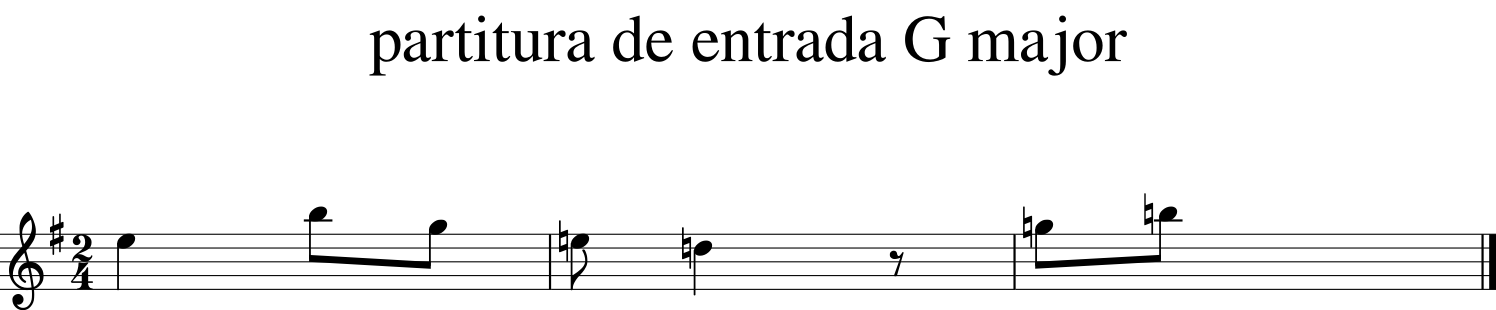

In [29]:
graficarPartitura2(partEntrada,"partitura de entrada",vocabReves)

/usr/local/lib/python3.8/dist-packages/music21/musicxml/m21ToXml.py:510: MusicXMLWarning: <music21.stream.Score 0x7f09b1098640> is not well-formed; see isWellFormedNotation()
  warnings.warn(f'{scOut} is not well-formed; see isWellFormedNotation()',


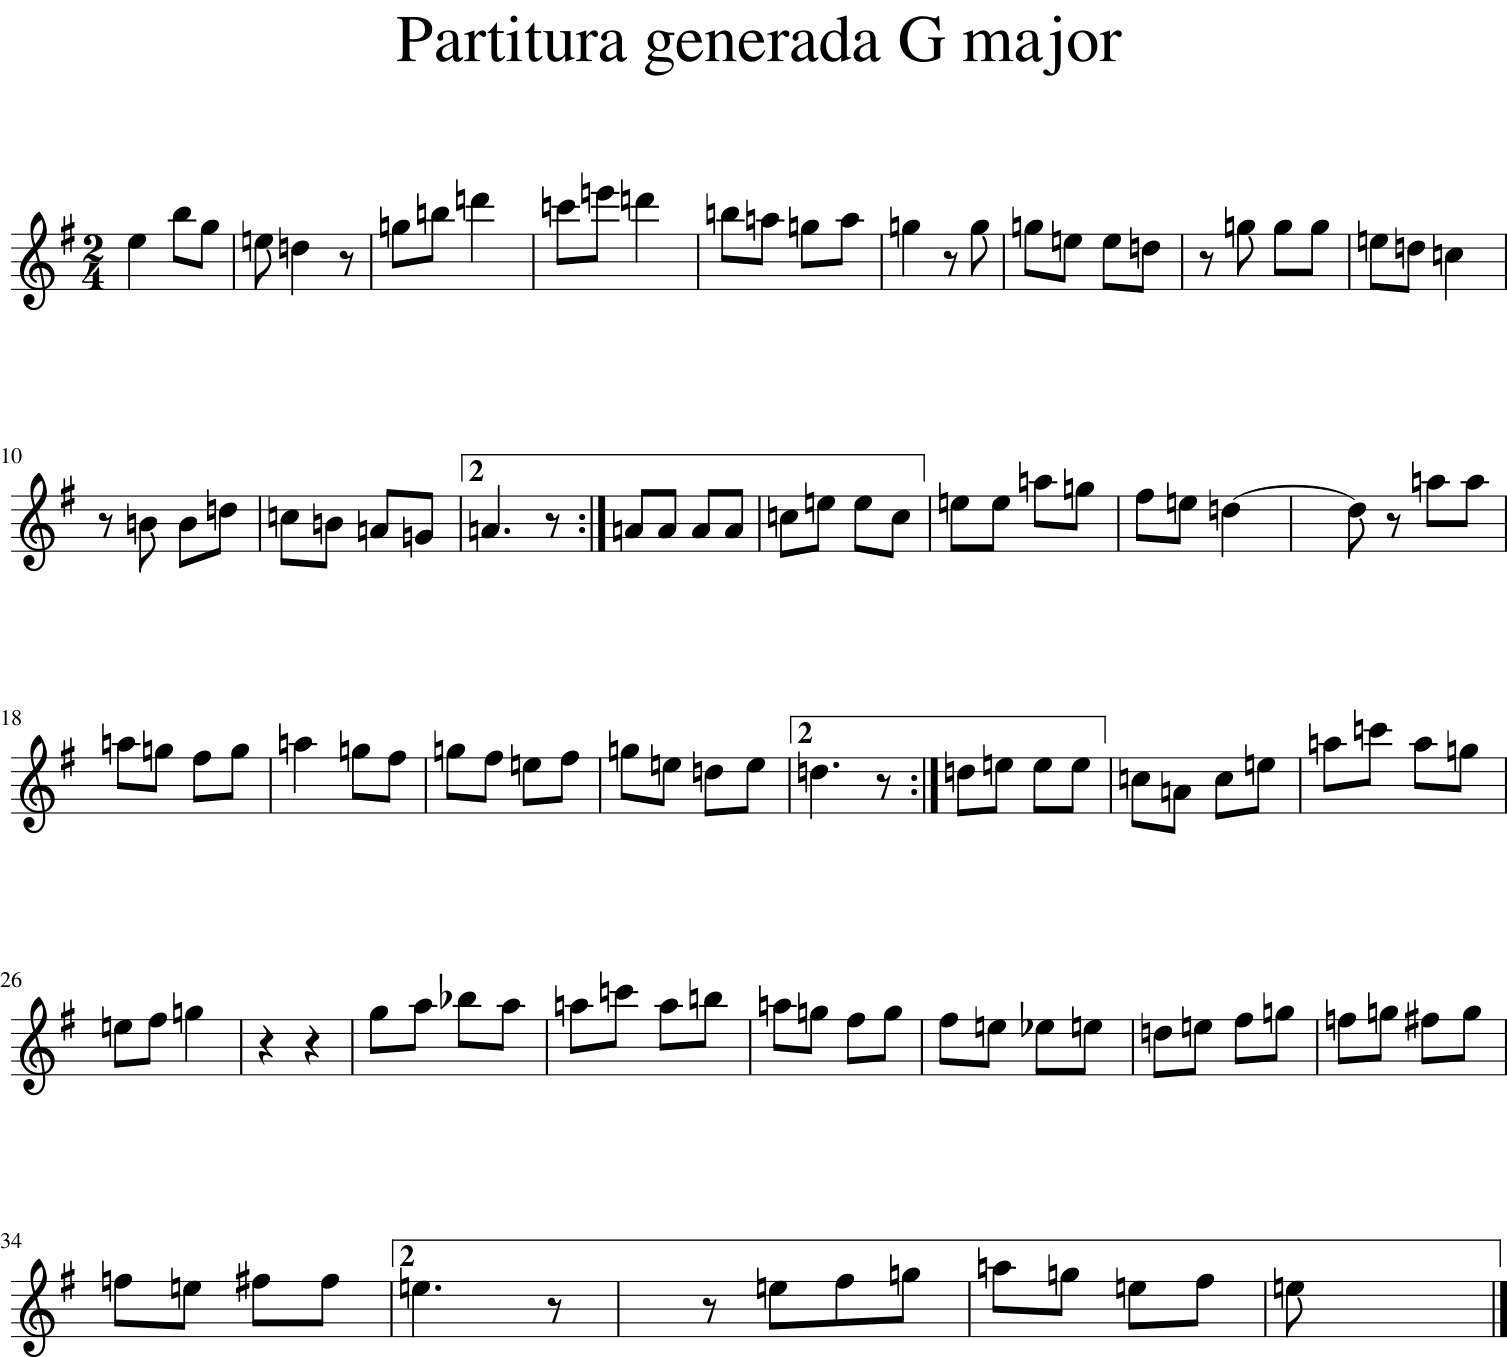

In [28]:
graficarPartitura2(partitura,"Partitura generada",vocabReves)